# Notebook for Wine Analysis

UMN Bootcamp Project 1 - Group 6

In [1]:
import pandas as pd
import re
import numpy as py
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

In [2]:
wine_data_file = "Resources/wine_data.csv"
wine_data = pd.read_csv(wine_data_file, encoding="utf-8")

wine_data.head()

,Unnamed: 0,country,description,designation,points,price (USD),province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,345,Australia,This wine contains some material over 100 year...,Rare,100,350.0,Victoria,Rutherglen,NaN,Joe Czerwinski,@JoeCz,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Muscat,Chambers Rosewood Vineyards
1,7335,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,NaN,NaN,NaN,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi
2,36528,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,Krug 2002 Brut (Champagne),Champagne Blend,Krug
3,39286,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,NaN,NaN,NaN,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia
4,42197,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,NaN,Roger Voss,@vossroger,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha


In [3]:
# Drop region 2, taster name, taster twitter handle, and unnamed column and ensure dataframe is clean/usable
clean_wine_data = wine_data.drop(["region_2", "taster_name", "taster_twitter_handle", "Unnamed: 0"], axis = 1)

# Extract the year from the title column and place it into a new column
# This is using the string extract function
clean_wine_data["Year"] = clean_wine_data["title"].str.extract("(\d{4})")

# Drop any rows that do not have a price, country, rating, or year
cleaned_wine_data = clean_wine_data.dropna(subset = ["price (USD)", "country", "points", "Year"])
cleaned_wine_data.head()

,country,description,designation,points,price (USD),province,region_1,title,variety,winery,Year
1,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi,1995
2,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,Krug 2002 Brut (Champagne),Champagne Blend,Krug,2002
3,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia,2007
4,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha,2008
5,Italy,"This gorgeous, fragrant wine opens with classi...",Riserva,100,550.0,Tuscany,Brunello di Montalcino,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi,2010


In [4]:
# Create a cleaned up version of the df for further analysis
wine_df = cleaned_wine_data.copy()

wine_df

,country,description,designation,points,price (USD),province,region_1,title,variety,winery,Year
1,Italy,Thick as molasses and dark as caramelized brow...,Occhio di Pernice,100,210.0,Tuscany,Vin Santo di Montepulciano,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Prugnolo Gentile,Avignonesi,1995
2,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,Krug 2002 Brut (Champagne),Champagne Blend,Krug,2002
3,Italy,"A perfect wine from a classic vintage, the 200...",Masseto,100,460.0,Tuscany,Toscana,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Merlot,Tenuta dell'Ornellaia,2007
4,Portugal,This is the latest release of what has long be...,Barca-Velha,100,450.0,Douro,NaN,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portuguese Red,Casa Ferreirinha,2008
5,Italy,"This gorgeous, fragrant wine opens with classi...",Riserva,100,550.0,Tuscany,Brunello di Montalcino,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi,2010
...,...,...,...,...,...,...,...,...,...,...,...
129965,US,"Simple but refreshing and crisp, with nice gra...",Dry,80,16.0,Missouri,Missouri,Montelle 2008 Dry Vignoles (Missouri),Vignoles,Montelle,2008
129966,US,This Chardonnay-Viognier blend is slightly swe...,Devil's Daughter,80,25.0,California,Contra Costa County,Bloomfield 2008 Devil's Daughter White (Contra...,White Blend,Bloomfield,2008
129967,US,"While there's some nice, honest fruit here, it...",NaN,80,14.0,Missouri,Missouri,Montelle 2008 Chambourcin (Missouri),Chambourcin,Montelle,2008
129969,US,"Short and slightly sweet, there's nutty overto...",Proprietor's Reserve,80,13.0,Pennsylvania,Pennsylvania,Chaddsford 2007 Proprietor's Reserve White (Pe...,White Blend,Chaddsford,2007


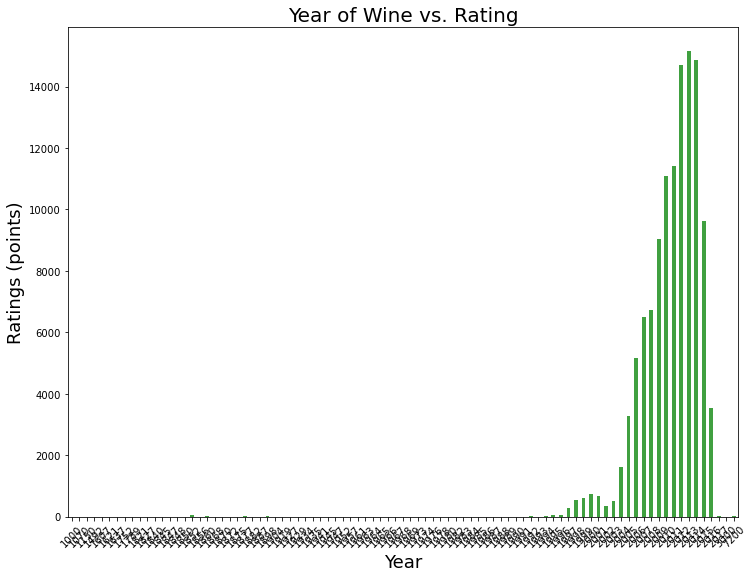

In [10]:
# Analyze and plot year of wine vs. rating
# Scatter plot vs. bar plot?? 
#Discuss with full group
wine_year = wine_df.groupby(["Year"])
total_ratings = wine_df.groupby(["Year"]).count()["points"]

total_ratings.plot(kind="bar", figsize = (12,9), color="g", alpha=0.75, legend=False, rot = 45)

#Assign labels and chart title
plt.title("Year of Wine vs. Rating", fontsize = 20)
plt.xlabel("Year", fontsize = 18)
plt.ylabel("Ratings (points)", fontsize = 18)

plt.show()

In [6]:
# Analyze price of wine vs. rating
# Scatter plot
wine_price = wine_df["price (USD)"]


In [7]:
# Analyze year of wine vs. price
# Scatter plot

In [8]:
# Identify countries with the most expensive wine
# Avg wine price by country
# Include a gmap

In [9]:
# Identify countries with the highest rated wine
# Avg wine ratings by country
# Include a gmap